In [1]:
import numpy as np
import scipy as sp
import json,sys,os
sys.path.append('../../')
import Project.profiles as pp
import Project.new_profiles as pnp
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['mathtext.fontset'] = 'dejavuserif'
import Project.quadrantHopping as qH
from tqdm.notebook import tqdm
from iminuit import Minuit
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pickle

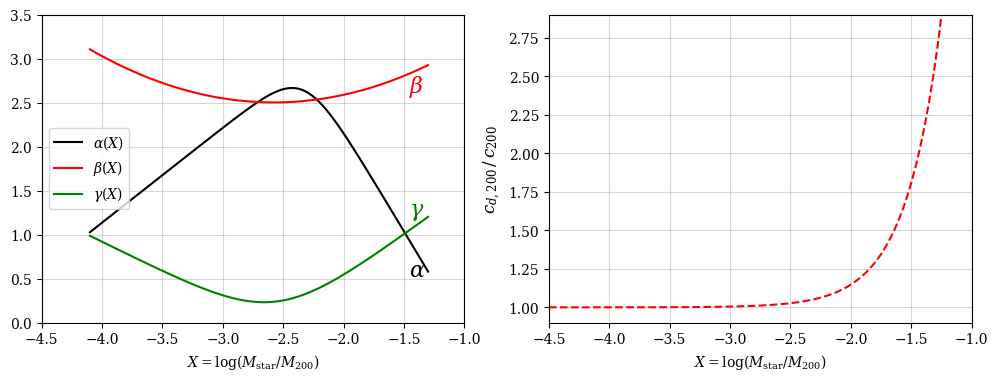

In [2]:
X = np.linspace(-4.1,-1.3,100)
A,B,C = [],[],[]
for x in X:
    a,b,c = pp.abc_dc14(x)
    A.append(a)
    B.append(b)
    C.append(c)
fig,axs = plt.subplots(1,2,figsize = (12,4))
ax1,ax2 = axs
ax1.plot(X,A,c = 'k',label = r'$\alpha(X)$')
ax1.plot(X,B,c = 'r',label = r'$\beta(X)$')
ax1.plot(X,C,c = 'g',label = r'$\gamma(X)$')
ax1.text(0.87,0.15,r'$\alpha$',size = 16, c = 'k',transform = ax1.transAxes)
ax1.text(0.87,0.75,r'$\beta$',size = 16, c = 'r',transform = ax1.transAxes)
ax1.text(0.87,0.35,r'$\gamma$',size = 16, c = 'g',transform = ax1.transAxes)
ax1.set_xlabel('$X = \mathrm{log}(M_{\mathrm{star}}/M_{200})$')
ax1.set_xlim(-4.5,-1)
ax1.set_ylim(0,3.5)
ax1.grid(alpha = 0.5)
ax1.legend()

X = np.linspace(-4.5,-1,100)
ax2.plot(X,pp.Csph_by_Cdm(X),c = 'r',ls = '--')
ax2.set_xlim(-4.5,-1)
ax2.set_ylim(0.9,2.9)
ax2.set_xlabel('$X = \mathrm{log}(M_{\mathrm{star}}/M_{200})$')
ax2.set_ylabel('$c_{d,200}\,/\,c_{200}$',size = 12)
ax2.grid(alpha = 0.5)

plt.savefig('../Output/figures/comparison/abc_dc14.pdf',bbox_inches = 'tight',dpi = 200)

In [3]:
LM = np.linspace(9.,13,9)
LS = pnp.lmstar_behroozi_19(LM)
C2 = 10**pp.lc200_SR(LM)

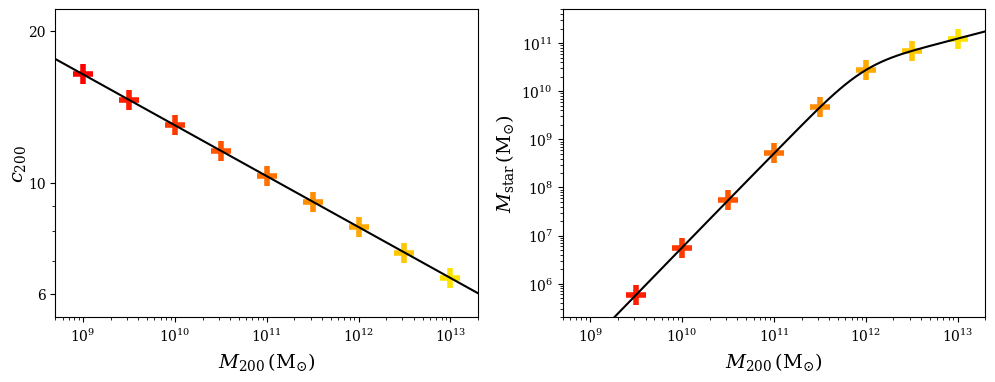

In [4]:
fig,axs = plt.subplots(1,2,figsize = (12,4))
ax1,ax2 = axs
cmap = 'autumn'

ax1.plot(10**np.linspace(8.,13.5,100),10**pp.lc200_SR(np.linspace(8.,13.5,100)), c = 'k')
ax2.plot(10**np.linspace(8.,13.5,100),10**pnp.lmstar_behroozi_19(np.linspace(8.,13.5,100)),c = 'k')

for i in range(9):
    ax1.scatter(10**LM[i],C2[i],s = 200, lw = 4, marker = '+', color = plt.get_cmap(cmap)((i/9)))
    ax2.scatter(10**LM[i],10**LS[i], marker = '+', s = 200,lw = 4, color = plt.get_cmap(cmap)(i/9))
    
ax1.set_ylabel('$c_{200}$',size = 14,labelpad = 0)
ax2.set_ylabel('$M_{\mathrm{star}} \, (\mathrm{M_{\odot}})$',size = 14)

for ax in axs:
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('$M_{200} \, (\mathrm{M_{\odot}})$',size = 14)
    ax.set_xlim(5e8,2e13)
    
ax2.set_ylim(2e5,5e11)
ax1.set_yticks([])
ax1.set_yticks([6,10,20])
ax1.set_yticklabels([6,10,20]);
plt.savefig('../Output/figures/comparison/mcr_shm.pdf',bbox_inches = 'tight',dpi = 300)

In [20]:
class Dc14:
    def __init__(self,lm,c2,ls):
        self.lm = lm
        self.c2 = c2
        self.ls = ls
        self.r200 = pp.r200_nfw(self.lm)
        self.rs= self.r200/self.c2
        self.r = np.logspace(-2,np.log10(self.r200),100)
        self.a,self.b,self.c = pp.abc_dc14(self.ls-self.lm)
        self.X = self.ls-self.lm
        self.rs_dc14 = pp.rs_dc14(self.lm,self.c2,self.X,self.a,self.b,self.c)
        
    def ρ_dc14(self,r):
        return pp.density_dc14(self.lm,self.ls,self.rs_dc14,r)
    def ρ_nfw(self,r):
        return pp.density_nfw(self.lm,self.rs,r)
    def M_dc14(self,r):
        return pp.mass_dc14(self.lm,self.ls,self.rs_dc14,r)
    def M_nfw(self,r):
        return pp.mass_nfw(self.lm,self.rs,r)
    def v_dc14(self,r):
        return pp.v_dc14(self.lm,self.ls,self.rs_dc14,r)
    def v_nfw(self,r):
        return pp.v_nfw(self.lm,self.rs,r)

In [21]:
dc14s = []
for i in range(9):
    lm,c2,ls = LM[i],C2[i],LS[i]
    dc14 = Dc14(lm,c2,ls)
    dc14s.append(dc14)

In [22]:
with open('../Output/data/DC14_9RCs.pkl','wb') as outp:
    pickle.dump(dc14s,outp,pickle.HIGHEST_PROTOCOL)

In [23]:
with open('../Output/data/DC14_9RCs.pkl','rb') as inp:
    dc14s = pickle.load(inp)

In [34]:
def get_core_params_v(r,v,p0 = None,upp_bounds = [14,np.inf,np.inf]):
    core_func = lambda r,lm,rs,rc: pp.v_sidm(lm,rs,rc,r)
    popt,pcov = sp.optimize.curve_fit(core_func,r,v,p0 = p0,bounds = ([8,0.1,0.1],upp_bounds))
    return popt

def get_core_params_ρ(logr,logrho, p0 = None, upp_bounds = [14,np.inf,np.inf]):
    core_func = lambda logr,lm,rs,rc: np.log10(pp.density_sidm(lm,rs,rc,10**logr))
    popt,pcov = sp.optimize.curve_fit(core_func,logr,logrho,p0 = p0,bounds = ([8.,0.1,0.1],upp_bounds))
    return popt

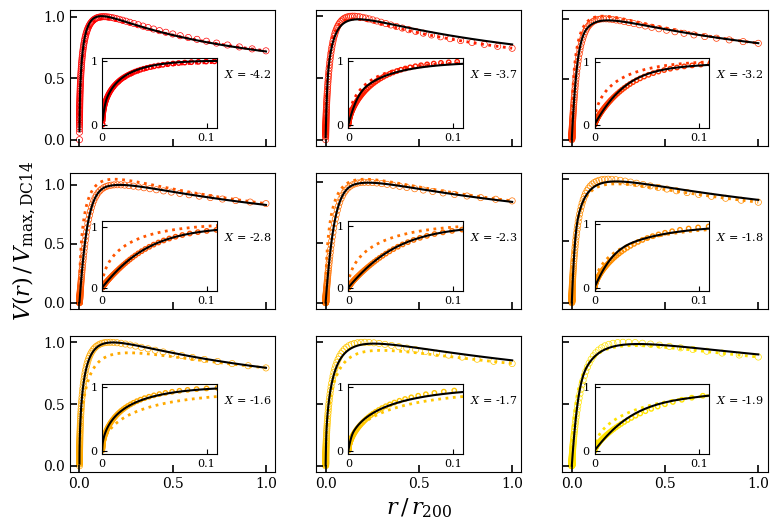

In [35]:
fig,axs = plt.subplots(3,3,figsize = (9,6))
axs = axs.flatten()
cmap = plt.get_cmap('autumn')
CP_vels = []
for i in range(9):
    ax = axs[i]
    dc14 = dc14s[i]
    r = dc14.r
    r200 = dc14.r200
    v = dc14.v_dc14(r)
    vscale = np.max(v)
    vnfw = dc14.v_nfw(r)
    cp = get_core_params_v(r,v,[9,1,1],[14,np.inf,5*dc14.rs])
    CP_vels.append(cp.tolist())
    vbnfw = pp.v_sidm(*cp[:3],r)
    
    ax.scatter(r/r200,v/vscale,color = cmap(i/9.), marker = 'o',facecolor = 'none',
              lw = 0.5, s = 20)
    ax.plot(r/r200,vnfw/vscale, color = cmap(i/9.), lw = 2, ls = ':')
    ax.plot(r/r200,vbnfw/vscale, color = 'k', lw = 1.5)
    if i%3: ax.set_yticklabels([])
    if i in [0,1,2,3,4,5]: ax.set_xticklabels([])
    if i == 3: ax.set_ylabel('$V(r)\,/\,V_{\mathrm{max,DC14}}$',size = 16)
    if i == 7: ax.set_xlabel('$r\,/\,r_{200}$',size = 16)
    ax.tick_params(which = 'both',direction = 'in',width = 1.2, length = 5)
    
    inset_ax = inset_axes(ax,width="70%",height=.7,bbox_to_anchor=(-0.05,-0.3,0.8,1),
                          bbox_transform = ax.transAxes)
    inset_ax.scatter(r/r200,v/vscale,color = plt.get_cmap(cmap)(i/9.),lw = 1,
                    marker = 'o', facecolor = 'none',s = 10)
    inset_ax.plot(r/r200,vnfw/vscale,color = plt.get_cmap(cmap)(i/9.),lw =2,ls = ':')
    inset_ax.plot(r/r200,vbnfw/vscale,color = 'k')
    inset_ax.set_xlim(0,0.11)
    inset_ax.tick_params(which = 'both', direction = 'in',labelsize = 8)
    inset_ax.set_yticks([0,1])
    inset_ax.set_yticklabels([0,1])
    inset_ax.set_xticks([0,0.1])
    inset_ax.set_xticklabels([0,0.1]) 
    ax.text(0.75,0.5,'$X$ = %.1f'%(dc14.X),size = 8,transform = ax.transAxes)
    
# plt.savefig('../Output/figures/comparison/DC14_RC.pdf',bbox_inches = 'tight',
# dpi = 300)

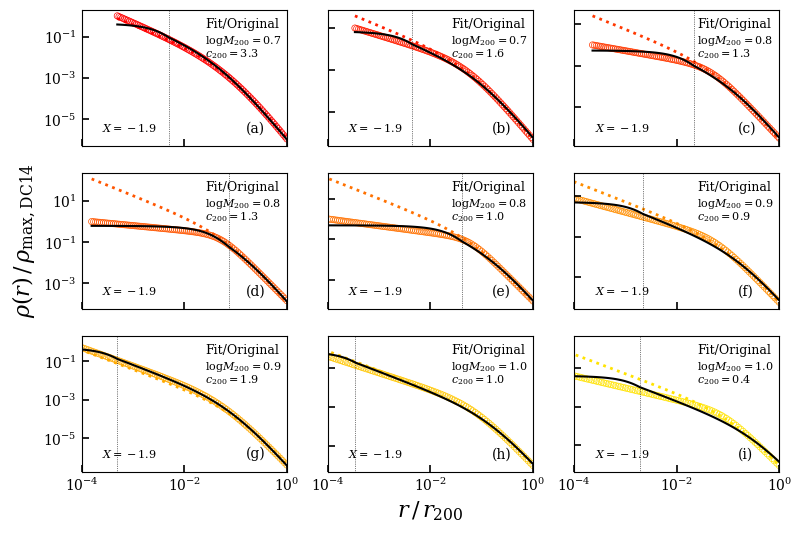

In [40]:
fig,axs = plt.subplots(3,3,figsize = (9,6))
axs = axs.flatten()
cmap = plt.get_cmap('autumn')
panels = ['a','b','c','d','e','f','g','h','i']
CP_dens = []
for i in range(9):
    ax = axs[i]
    dc14 = dc14s[i]
    r = dc14.r
    r200 = dc14.r200
    ρ = dc14.ρ_dc14(r)
    ρscale = np.max(ρ)
    ρnfw = dc14.ρ_nfw(r)
    cp = get_core_params_ρ(np.log10(r),np.log10(ρ),[9,1,1],[14,np.inf,5*dc14.rs])
    CP_dens.append(cp.tolist())
    ρbnfw = pp.density_sidm(*cp[:3],r)
    
    ax.scatter(r/r200,ρ/ρscale,color = cmap(i/9.), marker = 'o',facecolor = 'none',
              lw = 0.5, s = 20)
    ax.plot(r/r200,ρnfw/ρscale, color = cmap(i/9.), lw = 2, ls = ':')
    ax.plot(r/r200,ρbnfw/ρscale, color = 'k', lw = 1.5)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(1e-4,1e0)
    ylim = ax.get_ylim()
    ax.plot([cp[2]/r200,cp[2]/r200],ylim, c = 'k', ls = ':',lw = 0.5)
    ax.set_ylim(ylim)
    if i%3: ax.set_yticklabels([])
    if i in [0,1,2,3,4,5]: ax.set_xticklabels([])
    if i == 3: ax.set_ylabel(r'$\rho(r)\,/\,\rho_{\mathrm{max,DC14}}$',size = 16)
    if i == 7: ax.set_xlabel('$r\,/\,r_{200}$',size = 16)
    ax.tick_params(which = 'both',direction = 'in',width = 1.2, length = 5)
    ax.tick_params(which = 'both',direction = 'in',width = 1.2, length = 5)
    
    ax.text(0.6,0.87,'Fit/Original',size = 9,transform = ax.transAxes)
    ax.text(0.6,0.75,'$\mathrm{log}M_{200}=%.1f$'%(cp[0]/lm),size = 8, transform = ax.transAxes)
    ax.text(0.6,0.65,'$c_{200} = %.1f$'%(pnp.c200_nfw(cp[0],cp[1])/c2),size = 8, transform = ax.transAxes)
    ax.text(0.1,0.1,'$X = %.1f$'%(ls-lm),size = 8, transform = ax.transAxes)
    ax.text(0.8,0.1,'(%s)'%panels[i], size = 10, transform = ax.transAxes)
    
# plt.savefig('../Output/figures/comparison/DC14_density.pdf',bbox_inches = 'tight',
# dpi = 300)

In [41]:
CP = {'vels':CP_vels, 'dens':CP_dens}
json.dump(CP, open('../Output/data/DC14_BNFW_fit.json','w'),indent = 2)

In [42]:
L_M = np.linspace(9,13,100)
L_S = pnp.lmstar_behroozi_19(L_M)
C_2 = 10**pp.lc200_SR(L_M)
C_D,C_B,C_P = [],[],[]
R_S,R_D = [],[]
X = []
for i in range(100):
    lm,ls,c2 = L_M[i],L_S[i],C_2[i]
    a,b,c = pp.abc_dc14(ls-lm)
    rs_dc14 = pp.rs_dc14(lm,c2,ls-lm,a,b,c)
    r200 = pp.r200_nfw(lm)
    rs_nfw = r200/c2
    c200_dc14 = pp.Csph_by_Cdm(ls-lm)*c2
    C_D.append(c200_dc14)
    r = np.logspace(-2,np.log10(r200),100)
    vdc14 = pp.v_dc14(lm,ls,rs_dc14,r)
    cp = get_core_params(r,vdc14,[9,1,1],[14,np.inf,5*rs_nfw])
    # cp = get_Core_params(r,vdc14)
    c2_bnfw = pp.r200_nfw(cp[0])/cp[1]
    C_B.append(c2_bnfw)
    C_P.append(cp)
    R_S.append(rs_nfw)
    R_D.append(rs_dc14)
    X.append(ls-lm)
C_D = np.array(C_D)
C_B = np.array(C_B)
R_S = np.array(R_S)
R_D = np.array(R_D)

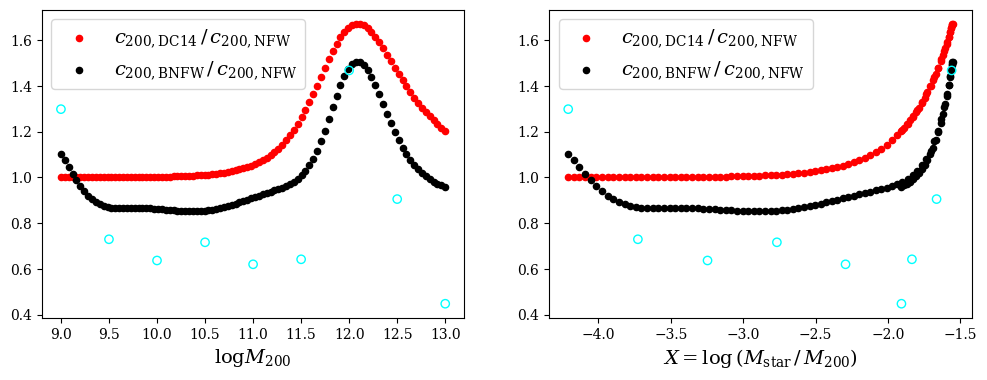

In [49]:
fig,axs = plt.subplots(1,2,figsize = (12,4))
ax1,ax2 = axs
ax1.scatter(L_M,C_D/C_2,c = 'r',label = r'$c_{200,\mathrm{DC14}}\,/\,c_{200,\mathrm{NFW}}$',
           marker = 'o',s = 20)
ax1.scatter(L_M,C_B/C_2,c = 'k',label = r'$c_{200,\mathrm{BNFW}}\,/\,c_{200,\mathrm{NFW}}$',
           marker = 'o',s = 20)
ax1.legend(prop = {'size':14})
ax1.set_xlabel('$\mathrm{log}M_{200}$',size = 14)

ax2.scatter(X,C_D/C_2,c = 'r',label = r'$c_{200,\mathrm{DC14}}\,/\,c_{200,\mathrm{NFW}}$',
            marker = 'o',s = 20)
ax2.scatter(X,C_B/C_2,c = 'k',label = r'$c_{200,\mathrm{BNFW}}\,/\,c_{200,\mathrm{NFW}}$',
            marker = 'o', s =20)
ax2.legend(prop = {'size':14})
ax2.set_xlabel('$X = \mathrm{log}\,(M_{\mathrm{star}}\,/\,M_{200})$',size = 14)

for i in range(9):
    cp = CP_dens[i]
    new_c2 = pnp.c200_nfw(*cp[:2])
    ax1.scatter(LM[i],new_c2/C2[i],color = 'cyan', facecolor = 'none')
    ax2.scatter(LS[i]-LM[i],new_c2/C2[i],color = 'cyan', facecolor = 'None')

# plt.savefig('../Output/figures/comparison/c200_comparison.pdf',bbox_inches = 'tight',dpi = 300)